1. Importing the data 

In [1]:
import pandas as pd

data = pd.read_csv("C:/Users/usuario/OneDrive/Escritorio/TFG/data.csv")

print(data.head())
print(data.columns)

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

2. Exploring the data

In [2]:
null_values_count = data.isna().sum()

if null_values_count.sum() == 0:
    print("There are no null values in the dataset.")
else:
    print(null_values_count[null_values_count > 0])

There are no null values in the dataset.


In [3]:
data.columns = data.columns.str.strip()

In [4]:
data.describe().T

count      mean  \
Bankrupt?                                           6819.0  0.032263   
ROA(C) before interest and depreciation before ...  6819.0  0.505180   
ROA(A) before interest and % after tax              6819.0  0.558625   
ROA(B) before interest and depreciation after tax   6819.0  0.553589   
Operating Gross Margin                              6819.0  0.607948   
...                                                    ...       ...   
Liability to Equity                                 6819.0  0.280365   
Degree of Financial Leverage (DFL)                  6819.0  0.027541   
Interest Coverage Ratio (Interest expense to EBIT)  6819.0  0.565358   
Net Income Flag                                     6819.0  1.000000   
Equity to Liability                                 6819.0  0.047578   

                                                         std  min       25%  \
Bankrupt?                                           0.176710  0.0  0.000000   
ROA(C) before interest and depreciation before ...  0.060686  0.0  0.476527   
ROA(A) before interest and % after tax              0.065620  0.0  0.535543   
ROA(B) before interest and depreciation after tax   0.061595  0.0  0.527277   
Operating Gross Margin                              0.016934  0.0  0.600445   
...                                                      ...  ...       ...   
Liability to Equity                                 0.014463  0.0  0.276944   
Degree of Financial Leverage (DFL)                  0.015668  0.0  0.026791   
Interest Coverage Ratio (Interest expense to EBIT)  0.013214  0.0  0.565158   
Net Income Flag                                     0.000000  1.0  1.000000   
Equity to Liability                                 0.050014  0.0  0.024477   

                                                         50%       75%  max  
Bankrupt?                                           0.000000  0.000000  1.0  
ROA(C) before interest and depreciation before ...  0.502706  0.535563  1.0  
ROA(A) before interest and % after tax              0.559802  0.589157  1.0  
ROA(B) before interest and depreciation after tax   0.552278  0.584105  1.0  
Operating Gross Margin                              0.605997  0.613914  1.0  
...                                                      ...       ...  ...  
Liability to Equity                                 0.278778  0.281449  1.0  
Degree of Financial Leverage (DFL)                  0.026808  0.026913  1.0  
Interest Coverage Ratio (Interest expense to EBIT)  0.565252  0.565725  1.0  
Net Income Flag                                     1.000000  1.000000  1.0  
Equity to Liability                                 0.033798  0.052838  1.0  

[96 rows x 8 columns]

3. Feature Selection for XGB Classifier

3.1. Removing variables with low variance (threshold = 0.1)

In [5]:
potential_features = data.columns.tolist()[1:]

features_to_use = []

for feature in potential_features:
    test1 = data[data['Bankrupt?'] == 0][feature].var() > 0.1
    test2 = data[data['Bankrupt?'] == 1][feature].var() > 0.1

    if test1 == True | test2 == True:
        features_to_use.append(feature)
    else:
        pass

print(f'The nº of features to use is {len(features_to_use)} and these are: \n {features_to_use}')

The nº of features to use is 23 and these are: 
 ['Operating Expense Rate', 'Research and development expense rate', 'Interest-bearing debt interest rate', 'Revenue Per Share (Yuan ¥)', 'Total Asset Growth Rate', 'Net Value Growth Rate', 'Current Ratio', 'Quick Ratio', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Average Collection Days', 'Inventory Turnover Rate (times)', 'Fixed Assets Turnover Frequency', 'Revenue per person', 'Allocation rate per person', 'Quick Assets/Current Liability', 'Cash/Current Liability', 'Inventory/Current Liability', 'Long-term Liability to Current Assets', 'Current Asset Turnover Rate', 'Quick Asset Turnover Rate', 'Cash Turnover Rate', 'Total assets to GNP price']


3.2. Checking for outliers and visualizing distributions

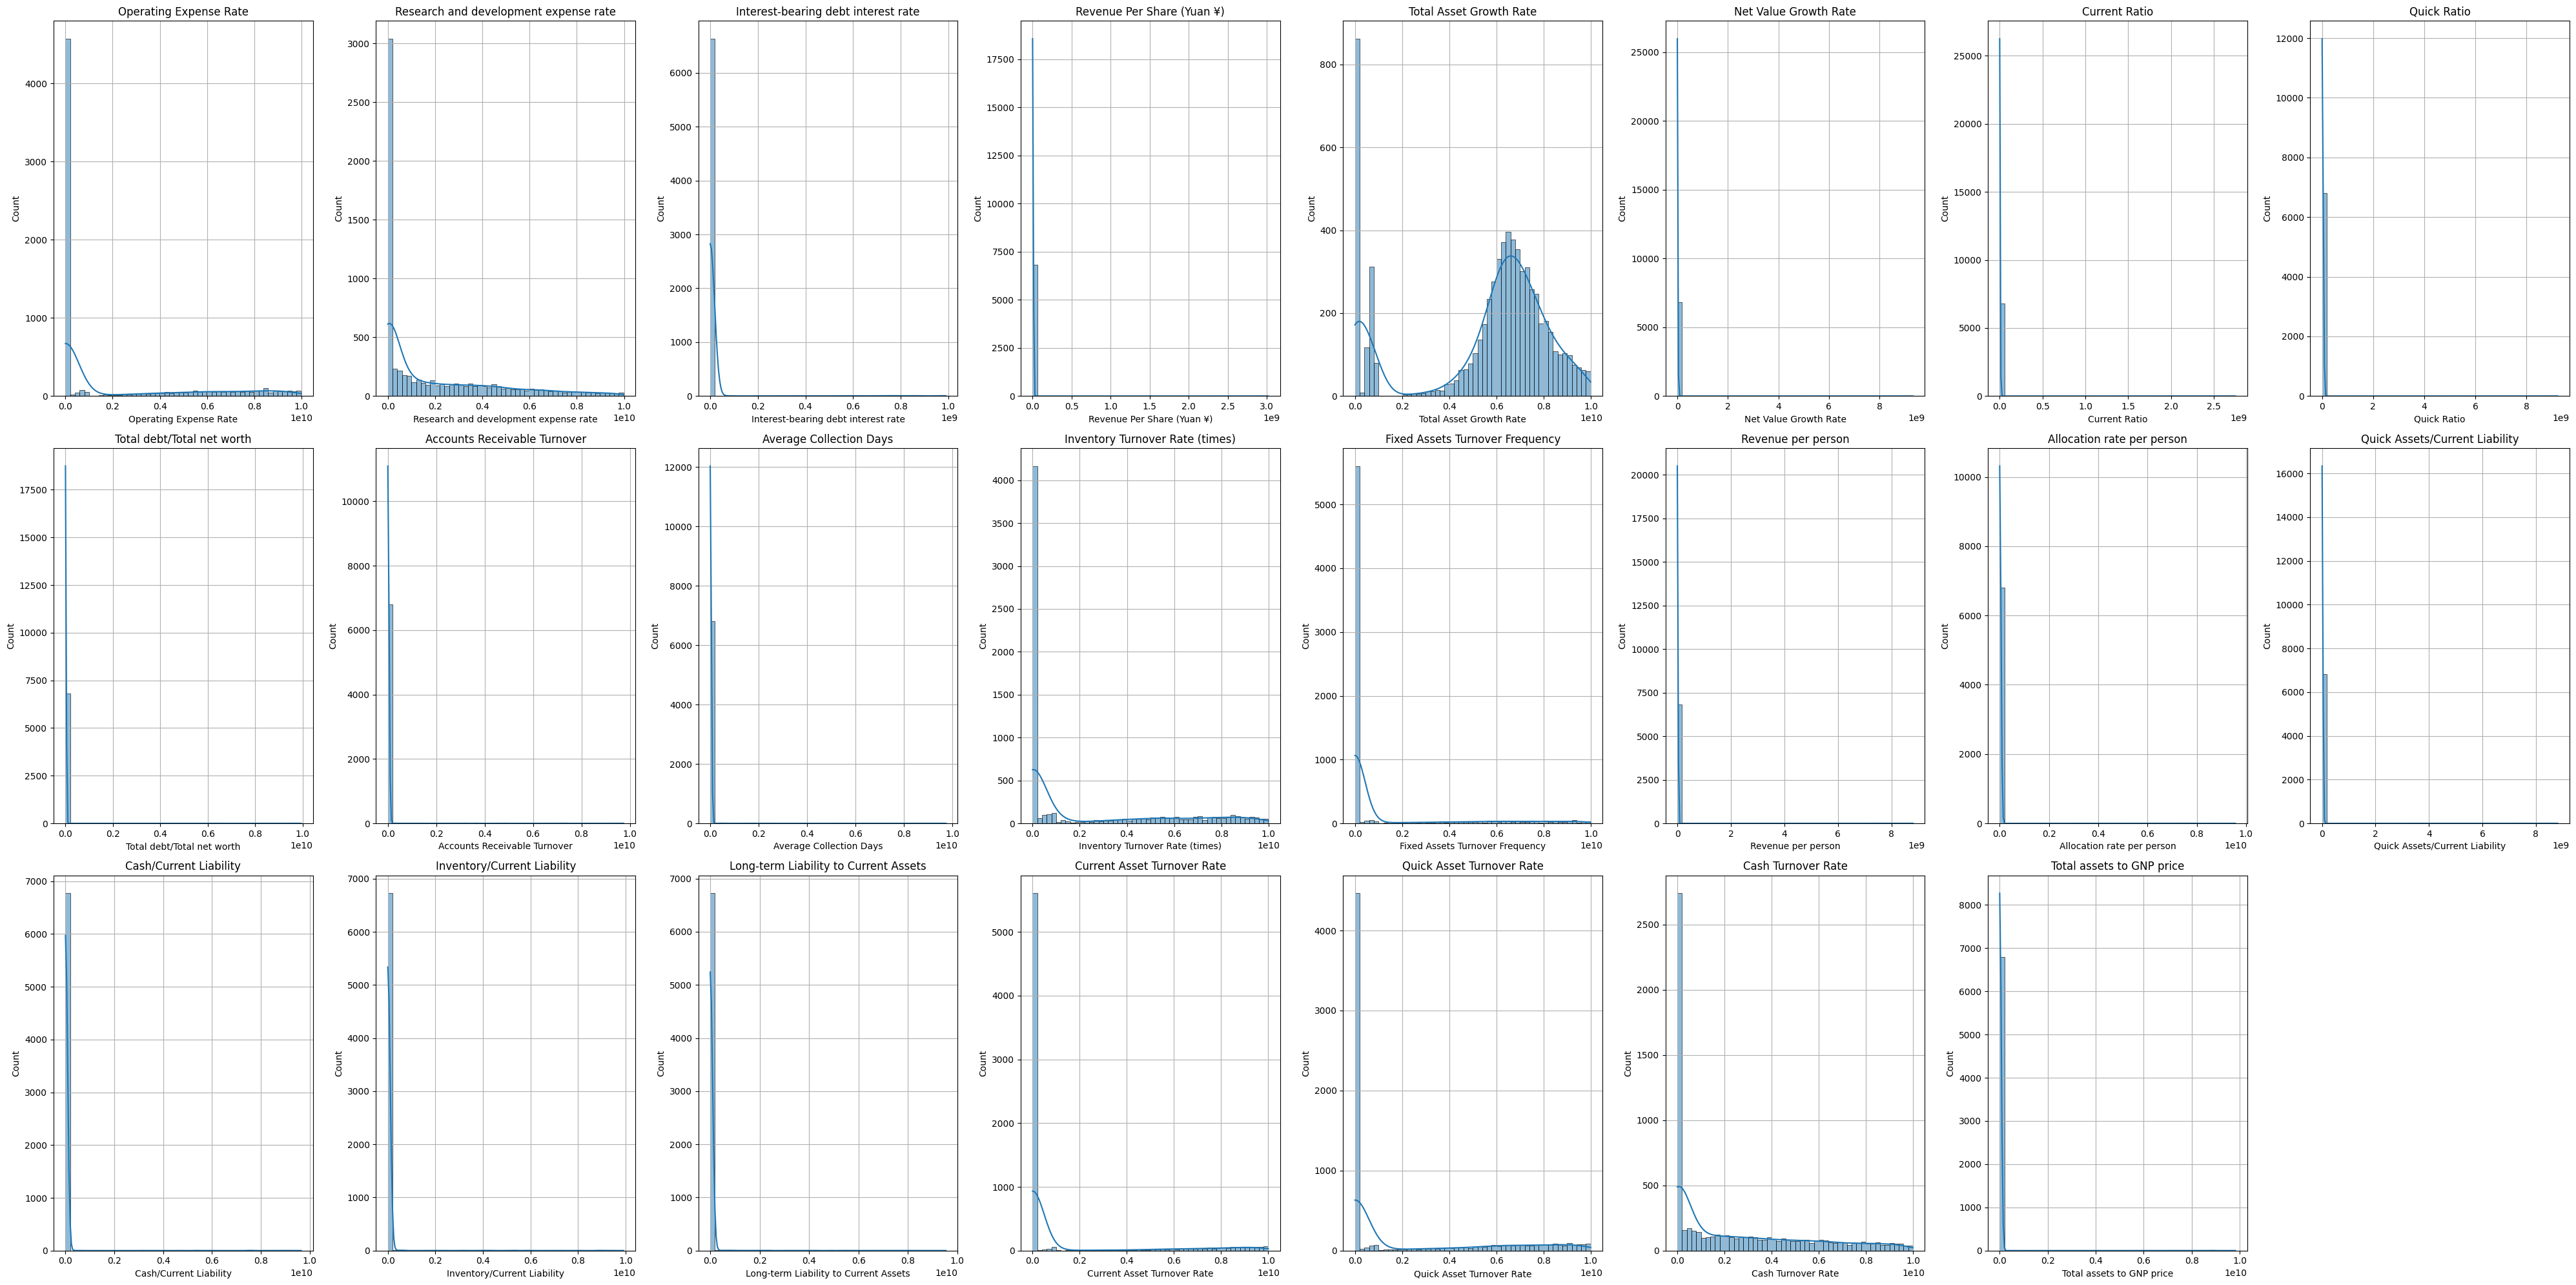

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

import math

ncols = 8  # Choose a fixed number of columns
nrows = math.ceil(len(features_to_use) / ncols)  # Compute rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 20))
axes = axes.flatten()

for ax, column in zip(axes, features_to_use):
    sns.histplot(data[column], ax=ax, kde=True, bins=50)  # Fixed number of bins
    ax.set_title(column)
    ax.grid(True)

# Hide unused subplots
for i in range(len(features_to_use), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

3.3. Checking for correlated variables and removing one of them to avoid multicolinearity.

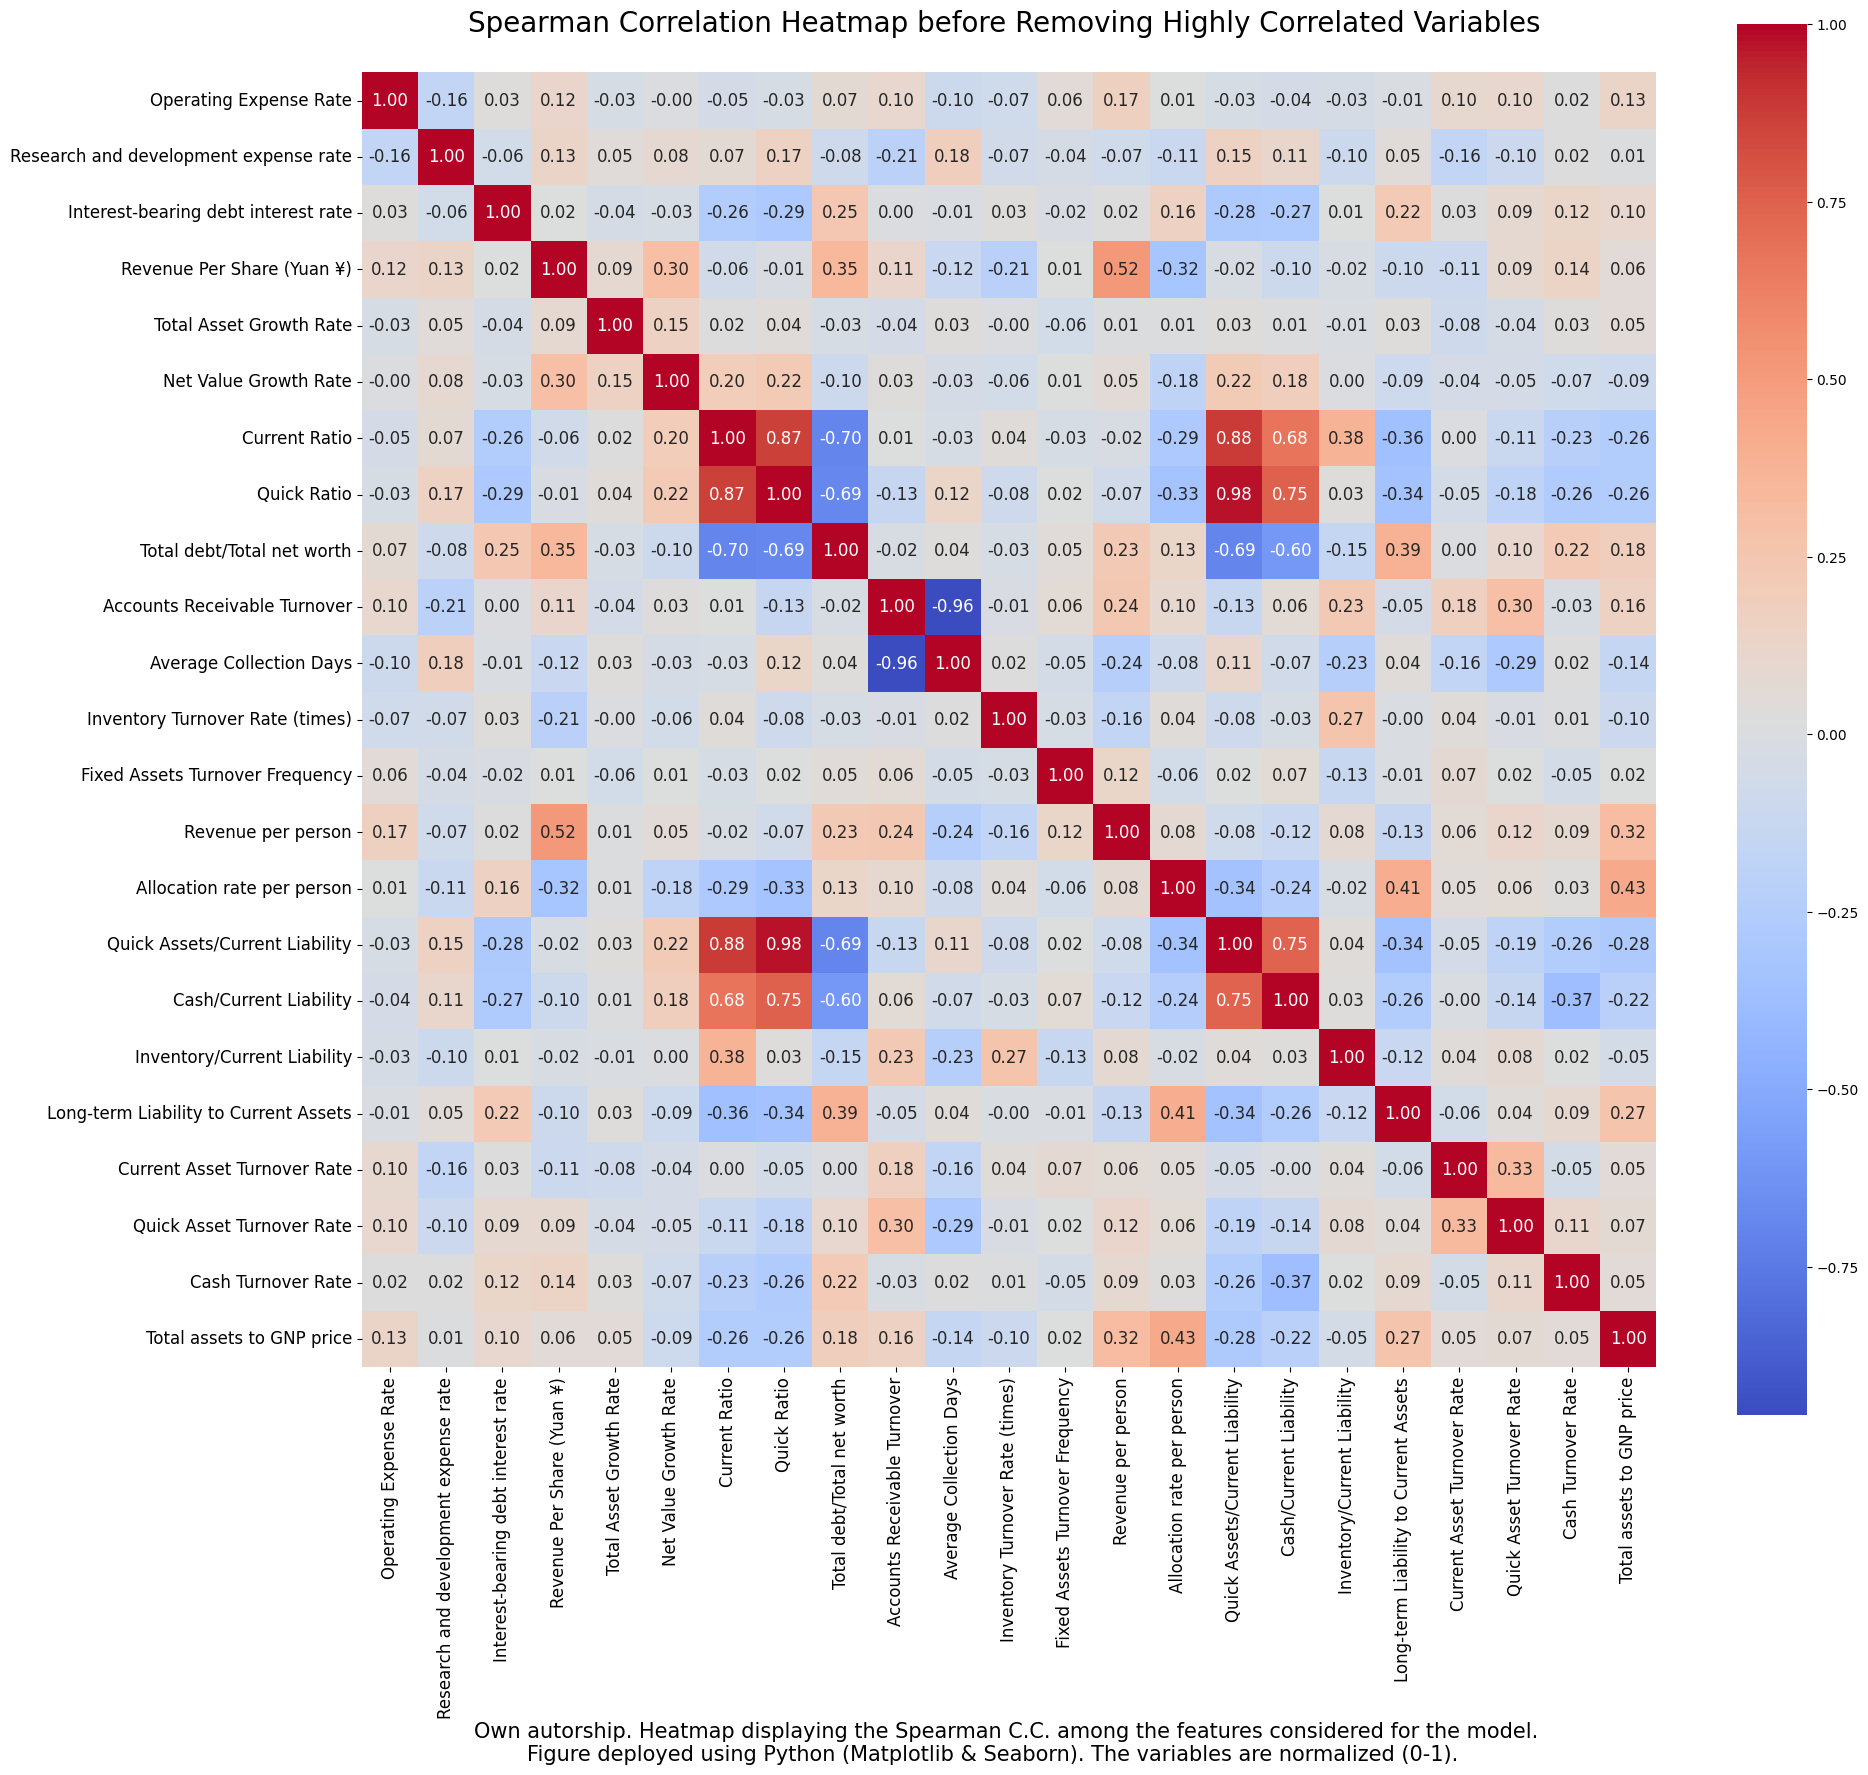

In [7]:
#Analyzing the correlation among the features in order to spot potential multicolinearity problems.

data_corr_matrix = data[features_to_use].corr('spearman')

plt.figure(figsize=(20, 20))

sns.heatmap(data_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.title('Spearman Correlation Heatmap before Removing Highly Correlated Variables \n', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(2, 30, 'Own autorship. Heatmap displaying the Spearman C.C. among the features considered for the model. \n' \
                '        Figure deployed using Python (Matplotlib & Seaborn). The variables are normalized (0-1).', fontsize=15)
plt.tight_layout()
plt.show()

In [8]:
#Removing features that are highly correlated with other features.

#features_to_use.remove('Current Liability to Liability')
#features_to_use.remove('Current Assets/Total Assets')

features_to_use.remove('Quick Assets/Current Liability')
features_to_use.remove('Cash/Current Liability')
features_to_use.remove('Accounts Receivable Turnover')
features_to_use.remove('Current Ratio')

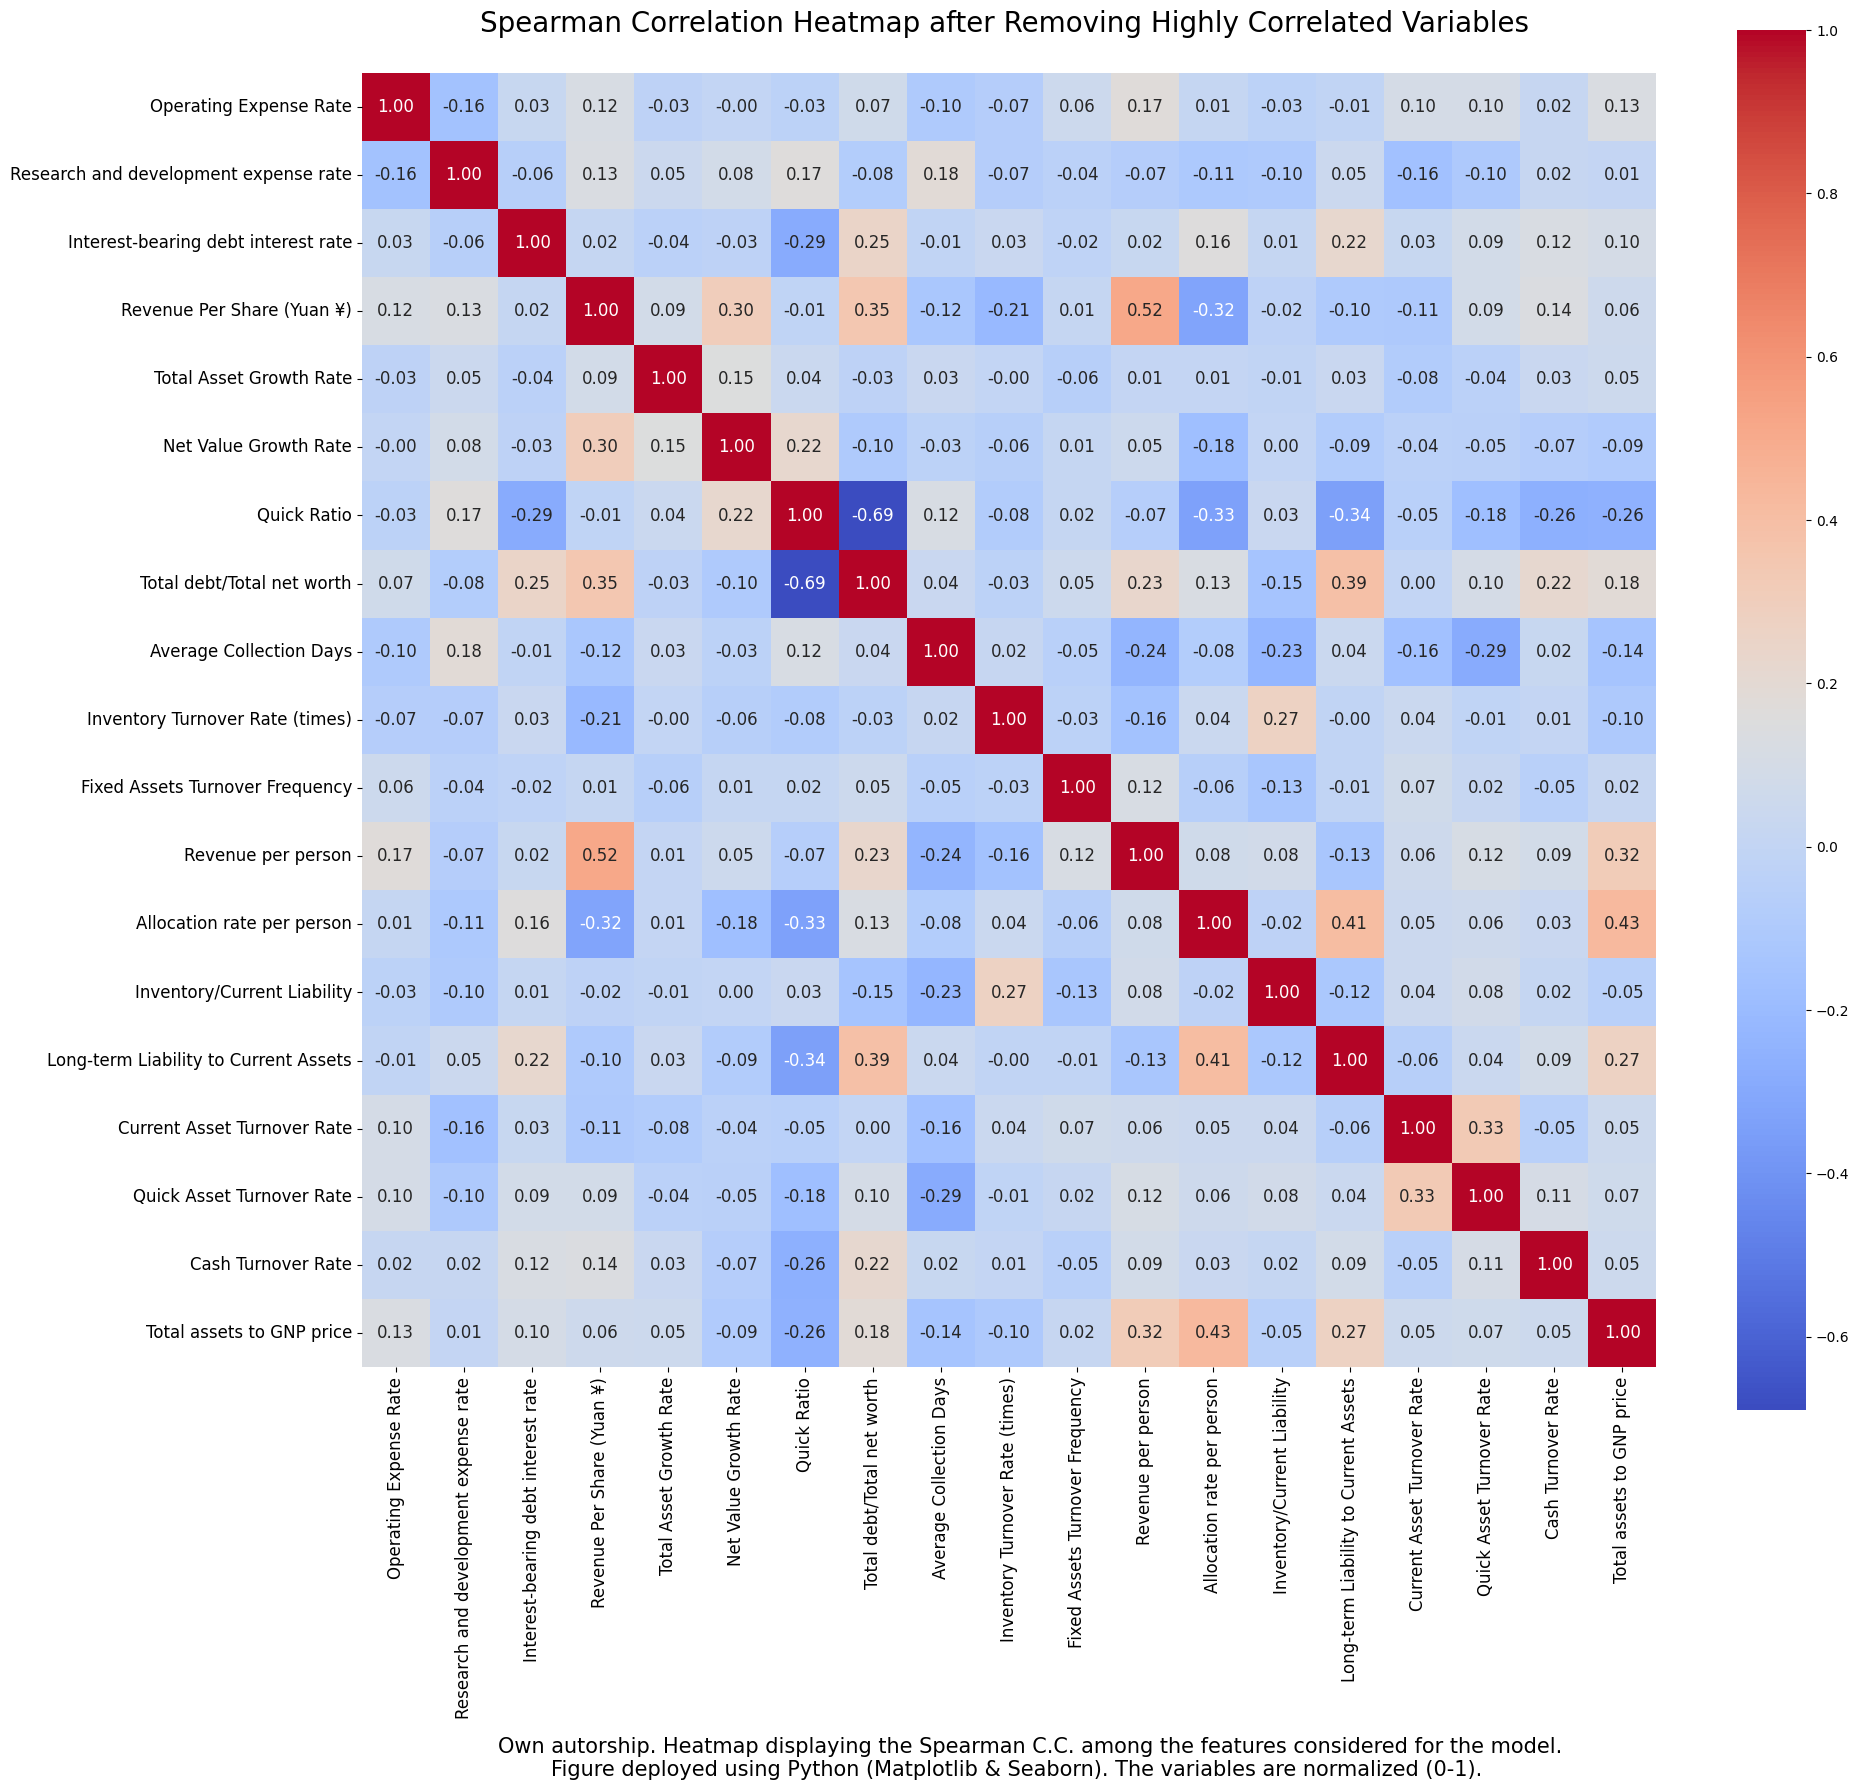

In [9]:
#Analyzing the correlation among the features in order to spot potential multicolinearity problems.

data_corr_matrix = data[features_to_use].corr('spearman')

plt.figure(figsize=(20, 20))

sns.heatmap(data_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.title('Spearman Correlation Heatmap after Removing Highly Correlated Variables \n', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(2, 25, 'Own autorship. Heatmap displaying the Spearman C.C. among the features considered for the model. \n' \
                '        Figure deployed using Python (Matplotlib & Seaborn). The variables are normalized (0-1).', fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
data[features_to_use].describe().T

count          mean           std  \
Operating Expense Rate                 6819.0  1.995347e+09  3.237684e+09   
Research and development expense rate  6819.0  1.950427e+09  2.598292e+09   
Interest-bearing debt interest rate    6819.0  1.644801e+07  1.082750e+08   
Revenue Per Share (Yuan ¥)             6819.0  1.328641e+06  5.170709e+07   
Total Asset Growth Rate                6819.0  5.508097e+09  2.897718e+09   
Net Value Growth Rate                  6819.0  1.566212e+06  1.141594e+08   
Quick Ratio                            6819.0  8.376595e+06  2.446847e+08   
Total debt/Total net worth             6819.0  4.416337e+06  1.684069e+08   
Average Collection Days                6819.0  9.826221e+06  2.563589e+08   
Inventory Turnover Rate (times)        6819.0  2.149106e+09  3.247967e+09   
Fixed Assets Turnover Frequency        6819.0  1.008596e+09  2.477557e+09   
Revenue per person                     6819.0  2.325854e+06  1.366327e+08   
Allocation rate per person             6819.0  1.125579e+07  2.945063e+08   
Inventory/Current Liability            6819.0  5.580680e+07  5.820516e+08   
Long-term Liability to Current Assets  6819.0  5.416004e+07  5.702706e+08   
Current Asset Turnover Rate            6819.0  1.195856e+09  2.821161e+09   
Quick Asset Turnover Rate              6819.0  2.163735e+09  3.374944e+09   
Cash Turnover Rate                     6819.0  2.471977e+09  2.938623e+09   
Total assets to GNP price              6819.0  1.862942e+07  3.764501e+08   

                                       min           25%           50%  \
Operating Expense Rate                 0.0  1.566874e-04  2.777589e-04   
Research and development expense rate  0.0  1.281880e-04  5.090000e+08   
Interest-bearing debt interest rate    0.0  2.030203e-04  3.210321e-04   
Revenue Per Share (Yuan ¥)             0.0  1.563138e-02  2.737571e-02   
Total Asset Growth Rate                0.0  4.860000e+09  6.400000e+09   
Net Value Growth Rate                  0.0  4.409689e-04  4.619555e-04   
Quick Ratio                            0.0  4.725903e-03  7.412472e-03   
Total debt/Total net worth             0.0  3.007049e-03  5.546284e-03   
Average Collection Days                0.0  4.386530e-03  6.572537e-03   
Inventory Turnover Rate (times)        0.0  1.728256e-04  7.646743e-04   
Fixed Assets Turnover Frequency        0.0  2.330013e-04  5.930942e-04   
Revenue per person                     0.0  1.043285e-02  1.861551e-02   
Allocation rate per person             0.0  4.120529e-03  7.844373e-03   
Inventory/Current Liability            0.0  3.163148e-03  6.497335e-03   
Long-term Liability to Current Assets  0.0  0.000000e+00  1.974619e-03   
Current Asset Turnover Rate            0.0  1.456236e-04  1.987816e-04   
Quick Asset Turnover Rate              0.0  1.417149e-04  2.247728e-04   
Cash Turnover Rate                     0.0  2.735337e-04  1.080000e+09   
Total assets to GNP price              0.0  9.036205e-04  2.085213e-03   

                                                75%           max  
Operating Expense Rate                 4.145000e+09  9.990000e+09  
Research and development expense rate  3.450000e+09  9.980000e+09  
Interest-bearing debt interest rate    5.325533e-04  9.900000e+08  
Revenue Per Share (Yuan ¥)             4.635722e-02  3.020000e+09  
Total Asset Growth Rate                7.390000e+09  9.990000e+09  
Net Value Growth Rate                  4.993621e-04  9.330000e+09  
Quick Ratio                            1.224911e-02  9.230000e+09  
Total debt/Total net worth             9.273293e-03  9.940000e+09  
Average Collection Days                8.972876e-03  9.730000e+09  
Inventory Turnover Rate (times)        4.620000e+09  9.990000e+09  
Fixed Assets Turnover Frequency        3.652371e-03  9.990000e+09  
Revenue per person                     3.585477e-02  8.810000e+09  
Allocation rate per person             1.502031e-02  9.570000e+09  
Inventory/Current Liability            1.114677e-02  9.910000e+09 

4. Model Building

4.1. Defining and Preprocessing the Data

In [11]:
X = data[features_to_use]

y = data[['Bankrupt?']]

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Check class distribution before SMOTE
print("Original class counts:", y['Bankrupt?'].value_counts())

# Split into train/test sets (SMOTE should ONLY be applied to training data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution after SMOTE
print("Resampled class counts:", y_train_resampled['Bankrupt?'].value_counts())

Original class counts: Bankrupt?
0    6599
1     220
Name: count, dtype: int64
Resampled class counts: Bankrupt?
0    5279
1    5279
Name: count, dtype: int64


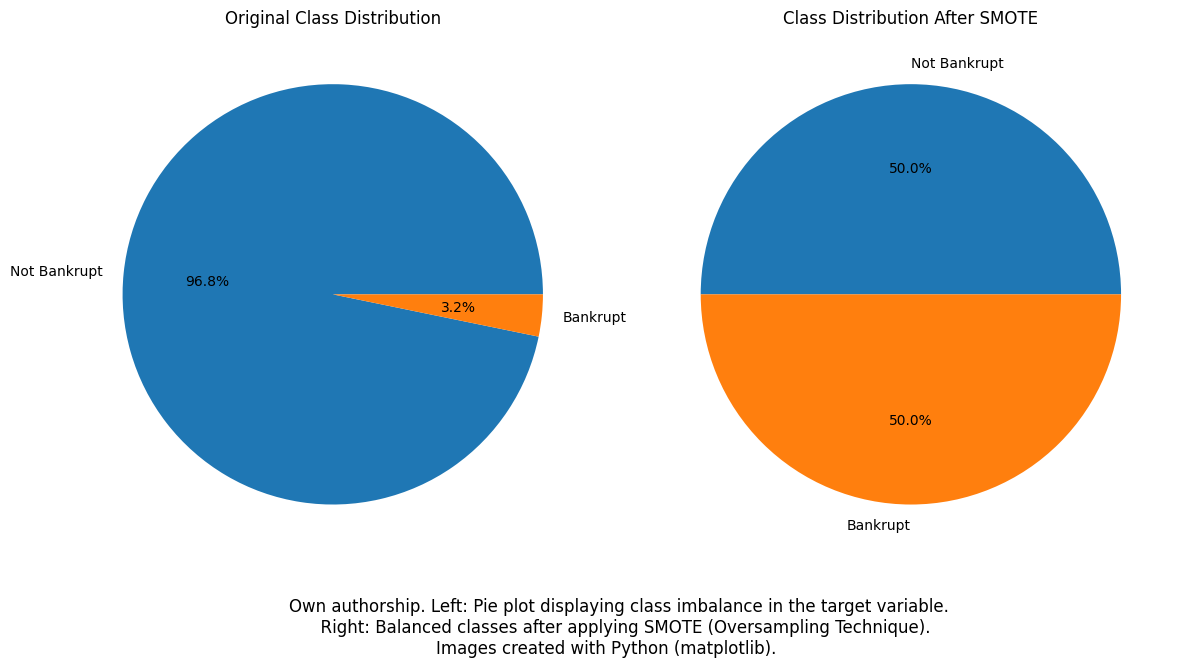

In [13]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Original class distribution
ax1.pie(y_train.value_counts(), labels=['Not Bankrupt', 'Bankrupt'], autopct='%1.1f%%')
ax1.set_title("Original Class Distribution")

# Plot 2: Class distribution after SMOTE
ax2.pie(y_train_resampled.value_counts(), labels=['Not Bankrupt', 'Bankrupt'], autopct='%1.1f%%')
ax2.set_title("Class Distribution After SMOTE")

# Add authorship text below the subplots
fig.text(0.25, -0.1, 
         'Own authorship. Left: Pie plot displaying class imbalance in the target variable.\n'
         '      Right: Balanced classes after applying SMOTE (Oversampling Technique).\n'
         '                            Images created with Python (matplotlib).', 
         ha='left', fontsize=12)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

4.2. Building the first model

In [14]:
# Best parameters
best_params = {'use_label_encoder': False, 'subsample': 0.7, 'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0.25, 'random_state': 13, 'objective': 'binary:logistic', 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'eval_metric': 'aucpr', 'colsample_bytree': 1}

# Train final model with best params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")

c:\Users\usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[1286   34]
 [  19   25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.42      0.57      0.49        44

    accuracy                           0.96      1364
   macro avg       0.70      0.77      0.73      1364
weighted avg       0.97      0.96      0.96      1364

ROC-AUC: 0.950


4.2.1. Analyzing feature importance.

c:\Users\usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 99%|===================| 1355/1364 [02:18<00:00]        

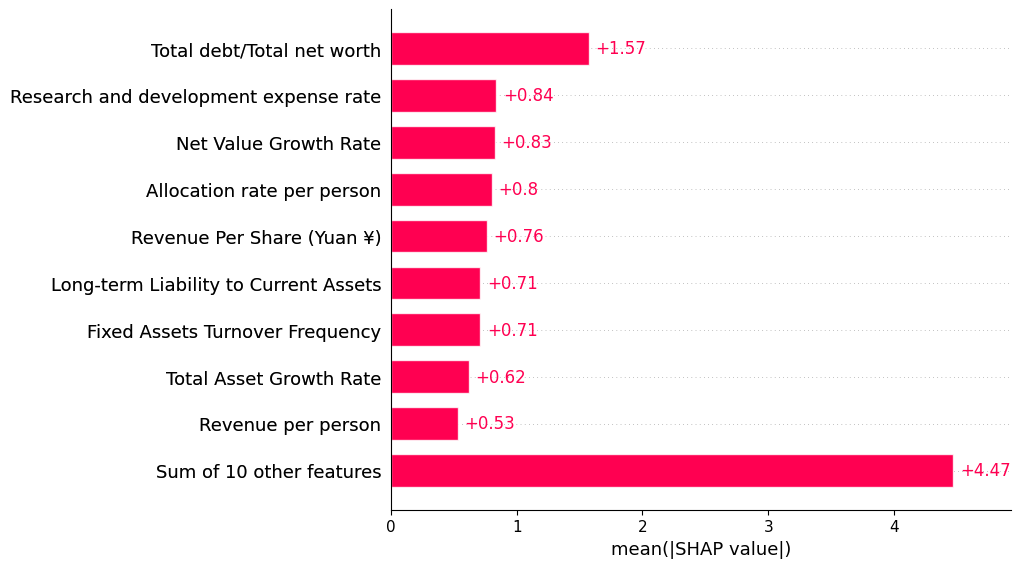

In [15]:
import shap
import numpy as np

shap.initjs()

# Create explainer
explainer = shap.Explainer(final_model, X_train)

# Calculate SHAP values (assuming X_test is your data)
shap_values = explainer(X_test)

np.shape(shap_values.values)

shap.plots.bar(shap_values)

<Figure size 1400x800 with 0 Axes>

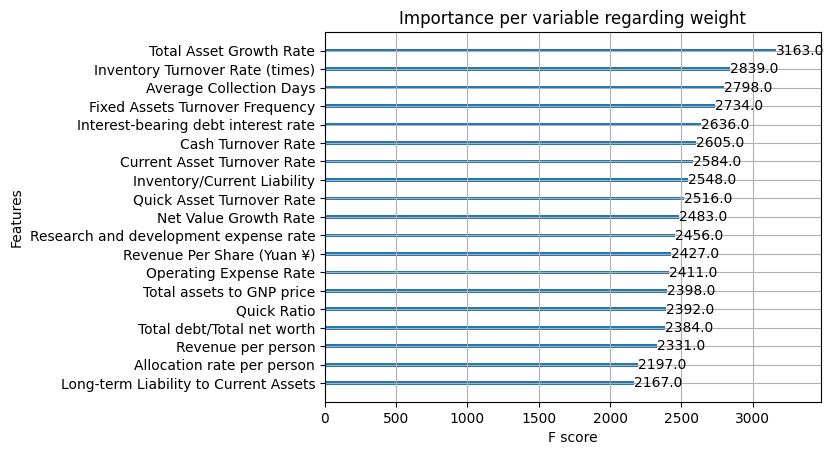

<Figure size 1400x800 with 0 Axes>

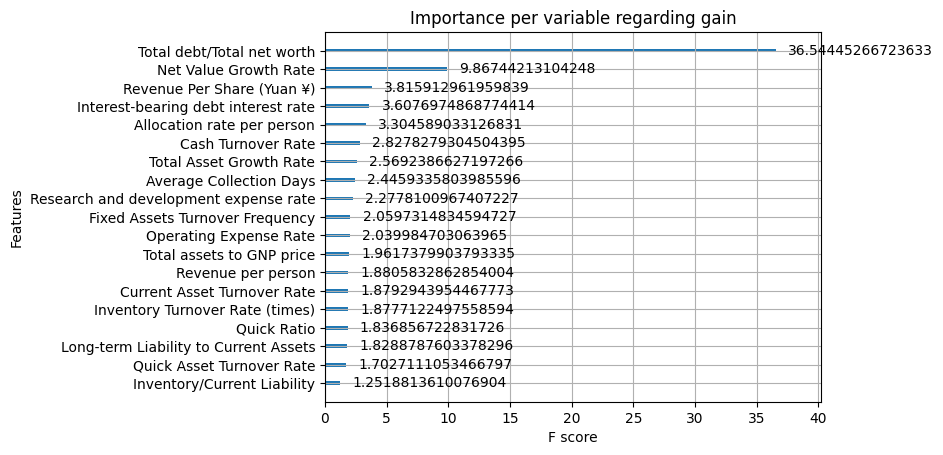

<Figure size 1400x800 with 0 Axes>

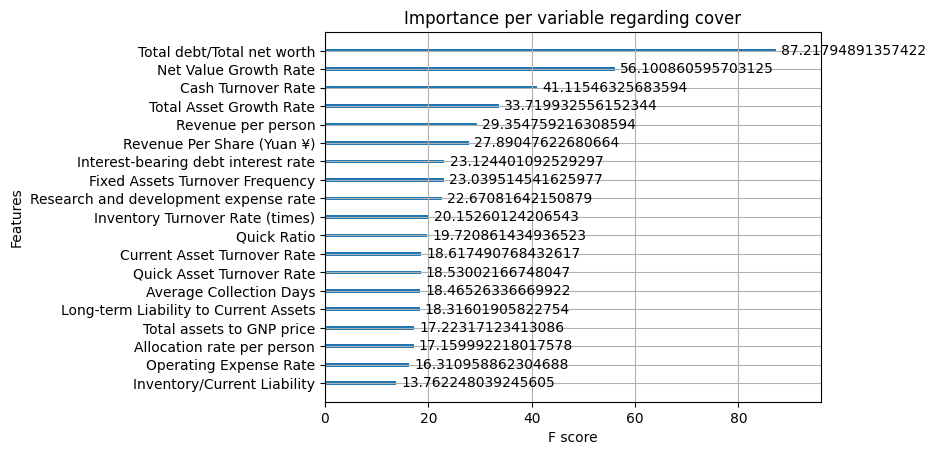

<Figure size 1400x800 with 0 Axes>

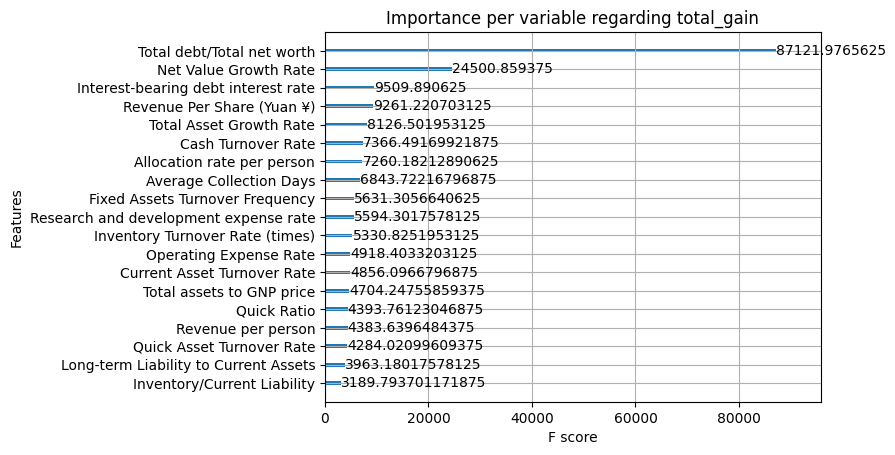

<Figure size 1400x800 with 0 Axes>

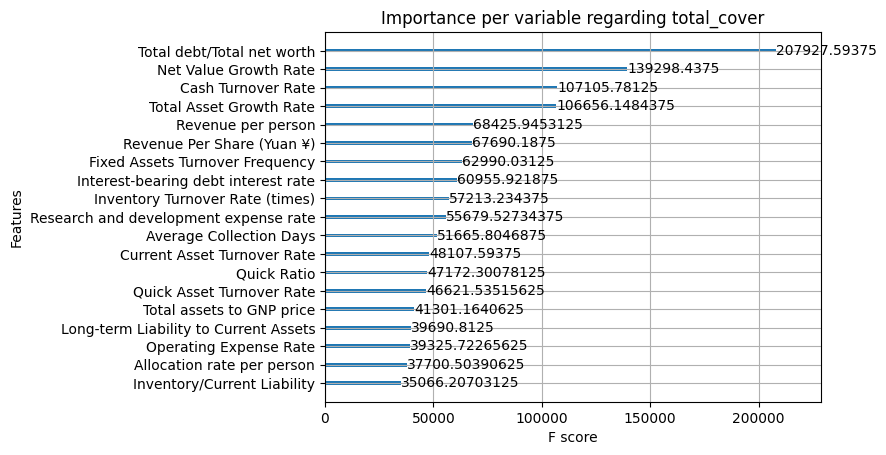

feature  weight       gain      cover  \
0              Total debt/Total net worth  2384.0  36.544453  87.217949   
1                   Net Value Growth Rate  2483.0   9.867442  56.100861   
2              Revenue Per Share (Yuan ¥)  2427.0   3.815913  27.890476   
3     Interest-bearing debt interest rate  2636.0   3.607697  23.124401   
4              Allocation rate per person  2197.0   3.304589  17.159992   
5                      Cash Turnover Rate  2605.0   2.827828  41.115463   
6                 Total Asset Growth Rate  3163.0   2.569239  33.719933   
7                 Average Collection Days  2798.0   2.445934  18.465263   
8   Research and development expense rate  2456.0   2.277810  22.670816   
9         Fixed Assets Turnover Frequency  2734.0   2.059731  23.039515   
10                 Operating Expense Rate  2411.0   2.039985  16.310959   
11              Total assets to GNP price  2398.0   1.961738  17.223171   
12                     Revenue per person  2331.0   1.880583  29.354759   
13            Current Asset Turnover Rate  2584.0   1.879294  18.617491   
14        Inventory Turnover Rate (times)  2839.0   1.877712  20.152601   
15                            Quick Ratio  2392.0   1.836857  19.720861   
16  Long-term Liability to Current Assets  2167.0   1.828879  18.316019   
17              Quick Asset Turnover Rate  2516.0   1.702711  18.530022   
18            Inventory/Current Liability  2548.0   1.251881  13.762248   

      total_gain    total_cover  
0   87121.976562  207927.593750  
1   24500.859375  139298.437500  
2    9261.220703   67690.187500  
3    9509.890625   60955.921875  
4    7260.182129   37700.503906  
5    7366.491699  107105.781250  
6    8126.501953  106656.148438  
7    6843.722168   51665.804688  
8    5594.301758   55679.527344  
9    5631.305664   62990.031250  
10   4918.403320   39325.722656  
11   4704.247559   41301.164062  
12   4383.639648   68425.945312  
13   4856.096680   48107.593750  
14   5330.825195   57213.234375  
15   4393.761230   47172.300781  
16   3963.180176   39690.812500  
17   4284.020996   46621.535156  
18   3189.793701   35066.207031

In [16]:
# Define importance types
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
importance_dict = {}

# Loop to collect importances and plot
for t in importance_types:
    # Get importance scores
    scores = final_model.get_booster().get_score(importance_type=t)
    
    # Add to the dictionary
    for feature, score in scores.items():
        if feature not in importance_dict:
            importance_dict[feature] = {}
        importance_dict[feature][t] = score

    # Plot
    plt.figure(figsize=(14, 8))
    xgb.plot_importance(final_model, importance_type=t)
    plt.title(f'Importance per variable regarding {t}')
    plt.show()

# Create the combined DataFrame
importances_df_model_1 = pd.DataFrame.from_dict(importance_dict, orient='index')
importances_df_model_1.fillna(0, inplace=True)
importances_df_model_1 = importances_df_model_1.sort_values(by='gain', ascending=False)

# Optional: Reset index for clarity
importances_df_model_1.reset_index(inplace=True)
importances_df_model_1.rename(columns={'index': 'feature'}, inplace=True)

# Display final DataFrame
display(importances_df_model_1)

4.3. Building a model with the K most important features.

In [17]:
top_most_important_features = importances_df_model_1.sort_values(by='total_gain', ascending=False)['feature'].head(18).tolist()

X = data[top_most_important_features]

y = data[['Bankrupt?']]

# Check class distribution before SMOTE
print("Original class counts:", y['Bankrupt?'].value_counts())

# Split into train/test sets (SMOTE should ONLY be applied to training data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution after SMOTE
print("Resampled class counts:", y_train_resampled['Bankrupt?'].value_counts())

# Best parameters
best_params = {'use_label_encoder': False,
               'subsample': 1,
               'scale_pos_weight': 1,
               'reg_lambda': 0.4,
               'reg_alpha': 0.1,
               'random_state': 13,
               'objective': 'binary:logistic',
               'n_estimators': 8000,
               'min_child_weight': 1,
               'max_depth': 7,
               'learning_rate': 0.1,
               'gamma': 0,
               'eval_metric': 'aucpr',
               'colsample_bytree': 1}

# Train final model with best params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")

Original class counts: Bankrupt?
0    6599
1     220
Name: count, dtype: int64
Resampled class counts: Bankrupt?
0    5279
1    5279
Name: count, dtype: int64


c:\Users\usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[1294   26]
 [  18   26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.50      0.59      0.54        44

    accuracy                           0.97      1364
   macro avg       0.74      0.79      0.76      1364
weighted avg       0.97      0.97      0.97      1364

ROC-AUC: 0.950


4.3.1. Analyzing Performance Metrics

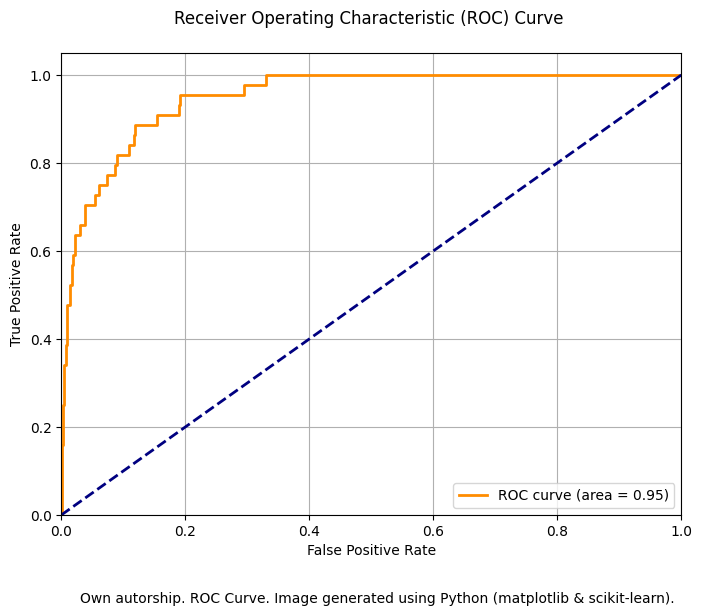

<Figure size 800x600 with 0 Axes>

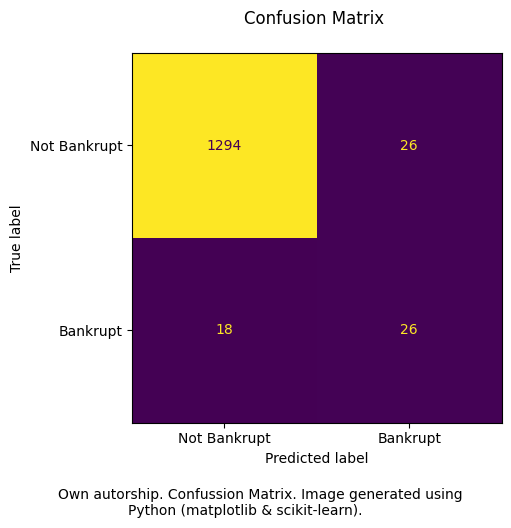

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# ... [your existing code up to the metrics section] ...

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve \n')
plt.text(0.03, -0.2, "Own autorship. ROC Curve. Image generated using Python (matplotlib & scikit-learn).")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                      display_labels=['Not Bankrupt', 'Bankrupt'],
                                      cmap=None, 
                                      colorbar=False)
plt.title('Confusion Matrix \n')
plt.text(-0.9, 2, "Own autorship. Confussion Matrix. Image generated using \n" \
                   "                Python (matplotlib & scikit-learn).")
plt.grid(False)
plt.show()

4.3.2. Analyzing Feature Importance

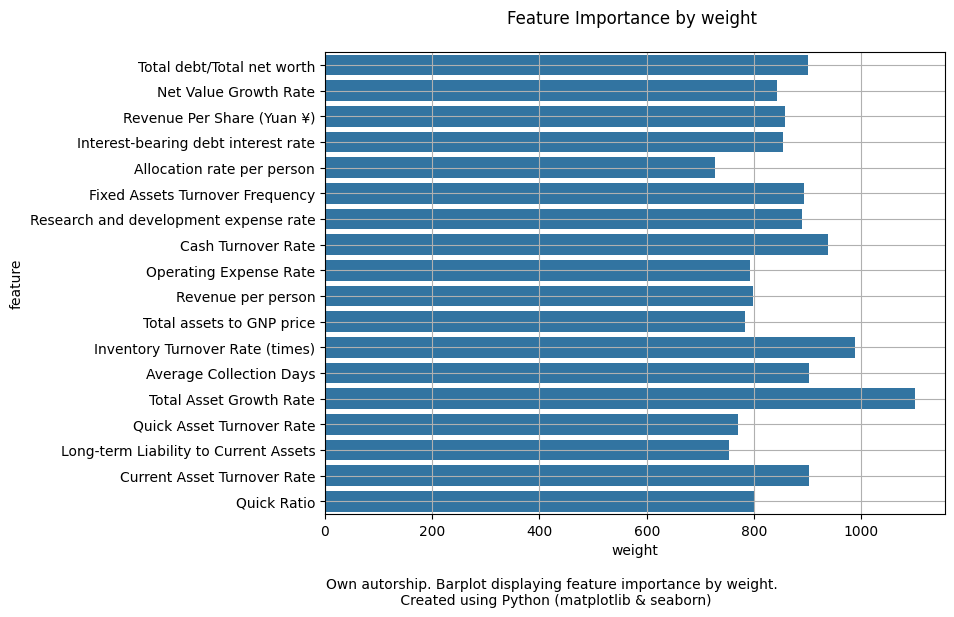

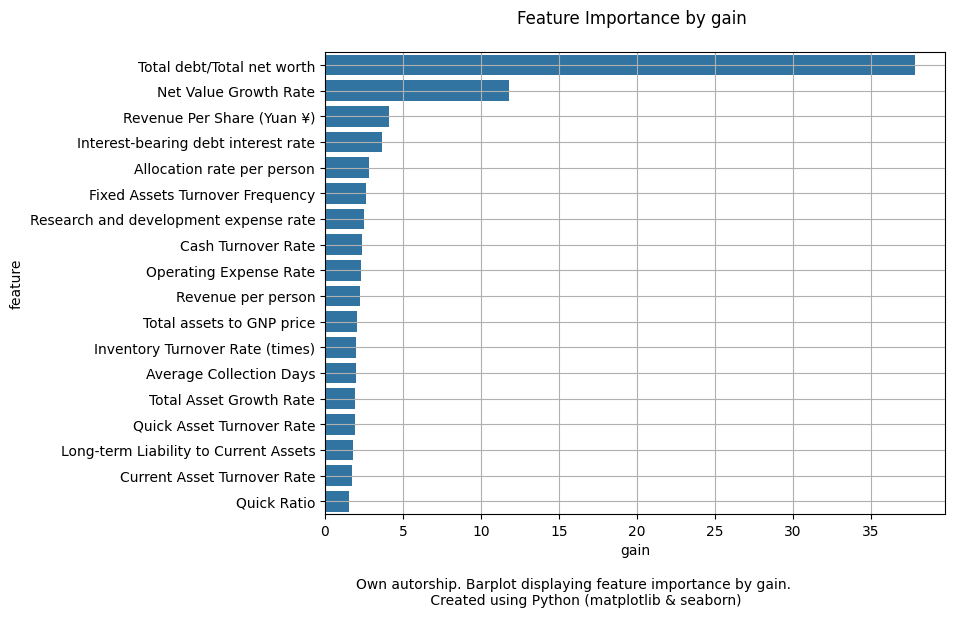

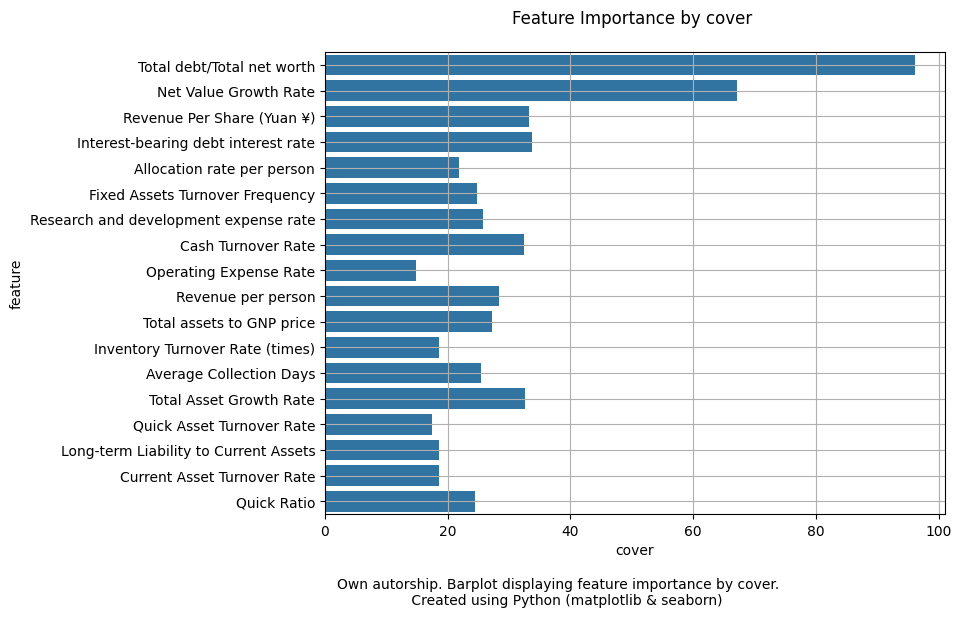

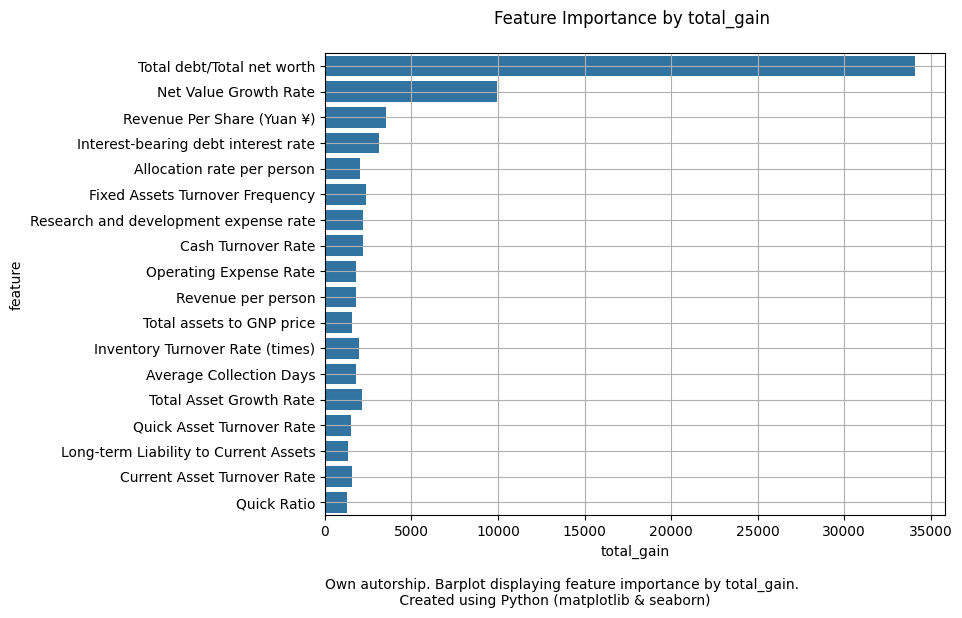

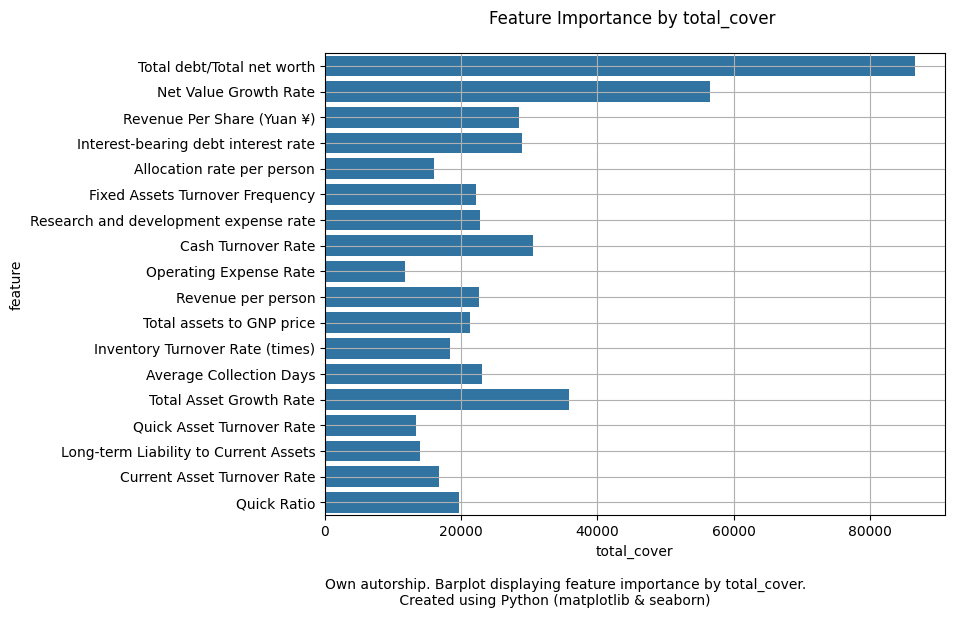

In [19]:
# Define importance types
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
importance_dict = {}

# Loop to collect importances and plot
for t in importance_types:
    # Get importance scores
    scores = final_model.get_booster().get_score(importance_type=t)
    
    # Add to the dictionary
    for feature, score in scores.items():
        if feature not in importance_dict:
            importance_dict[feature] = {}
        importance_dict[feature][t] = score

# Create the combined DataFrame
importances_df_model_2 = pd.DataFrame.from_dict(importance_dict, orient='index')
importances_df_model_2.fillna(0, inplace=True)
importances_df_model_2['gain'] = importances_df_model_2['gain'].round(2)
importances_df_model_2 = importances_df_model_2.sort_values(by='gain', ascending=False)

# Optional: Reset index for clarity
importances_df_model_2.reset_index(inplace=True)
importances_df_model_2.rename(columns={'index': 'feature'}, inplace=True)

#Plotting
for col in importances_df_model_2.drop(columns='feature').columns.tolist():
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances_df_model_2[col], y=importances_df_model_2['feature'])
    plt.title(f'Feature Importance by {col} \n')
    plt.text(2, 21, f'Own autorship. Barplot displaying feature importance by {col}. \n \
                Created using Python (matplotlib & seaborn)')
    plt.grid()
    plt.show()

4.3.3. Using Shap in order to analyze deeply the final model.

In [20]:
import shap
import numpy as np

shap.initjs()

# Create explainer and calculate SHAP values
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

# Convert SHAP values to mean absolute and round to 2 decimals
shap_summary = np.abs(shap_values.values).mean(axis=0)
shap_summary_rounded = np.round(shap_summary, 2)

100%|===================| 1361/1364 [00:36<00:00]        

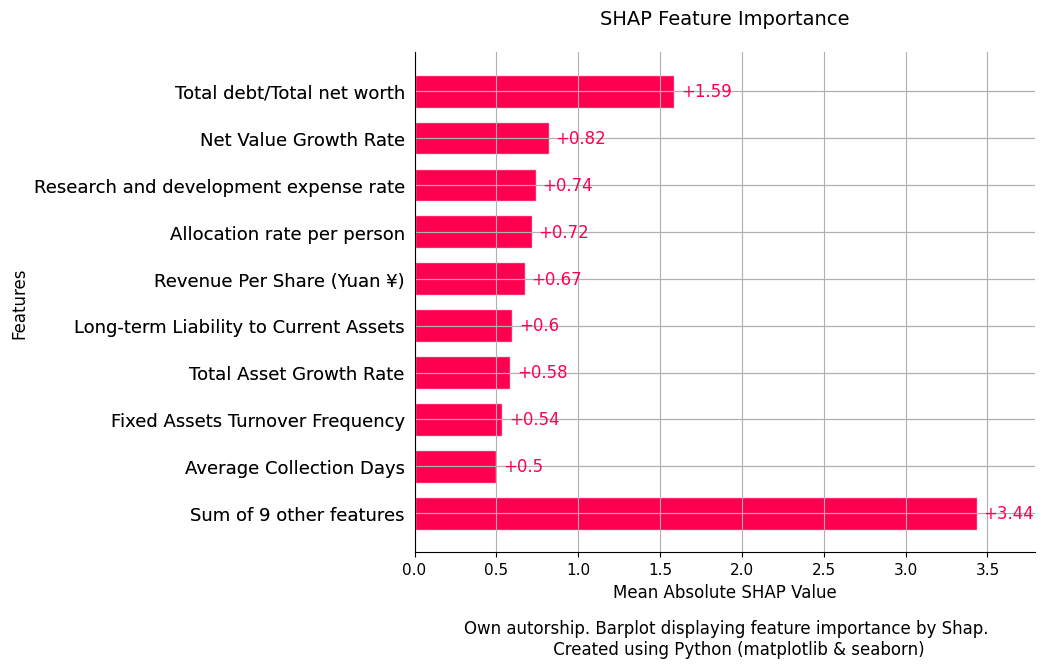

In [21]:
import shap
import matplotlib.pyplot as plt

# Generate the SHAP bar plot
shap.plots.bar(shap_values, show=False)  # `show=False` prevents auto-display

# Add a title and axis labels
plt.title("SHAP Feature Importance", fontsize=14, pad=20)
plt.xlabel("Mean Absolute SHAP Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.text(0.3, -2, f'Own autorship. Barplot displaying feature importance by Shap. \n \
                Created using Python (matplotlib & seaborn)', fontsize=12)
plt.grid()
# Display the plot
plt.show()

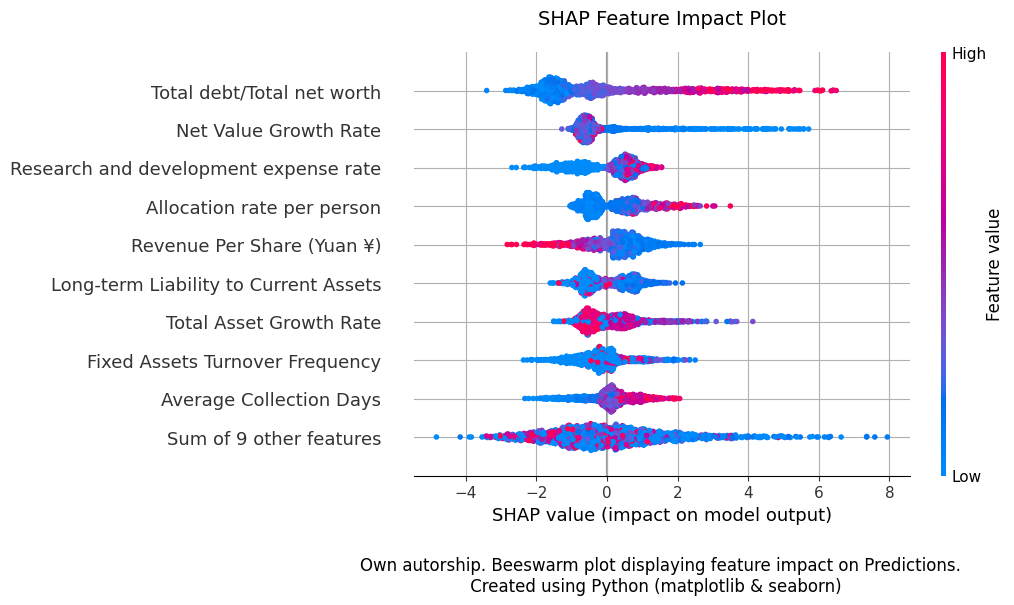

In [22]:
shap.plots.beeswarm(shap_values, show=False)

# Add a title and axis labels
plt.title("SHAP Feature Impact Plot", fontsize=14, pad=20)
plt.text(-7, -4, f'Own autorship. Beeswarm plot displaying feature impact on Predictions. \n \
                    Created using Python (matplotlib & seaborn)', fontsize=12)
plt.grid()
# Display the plot
plt.show()

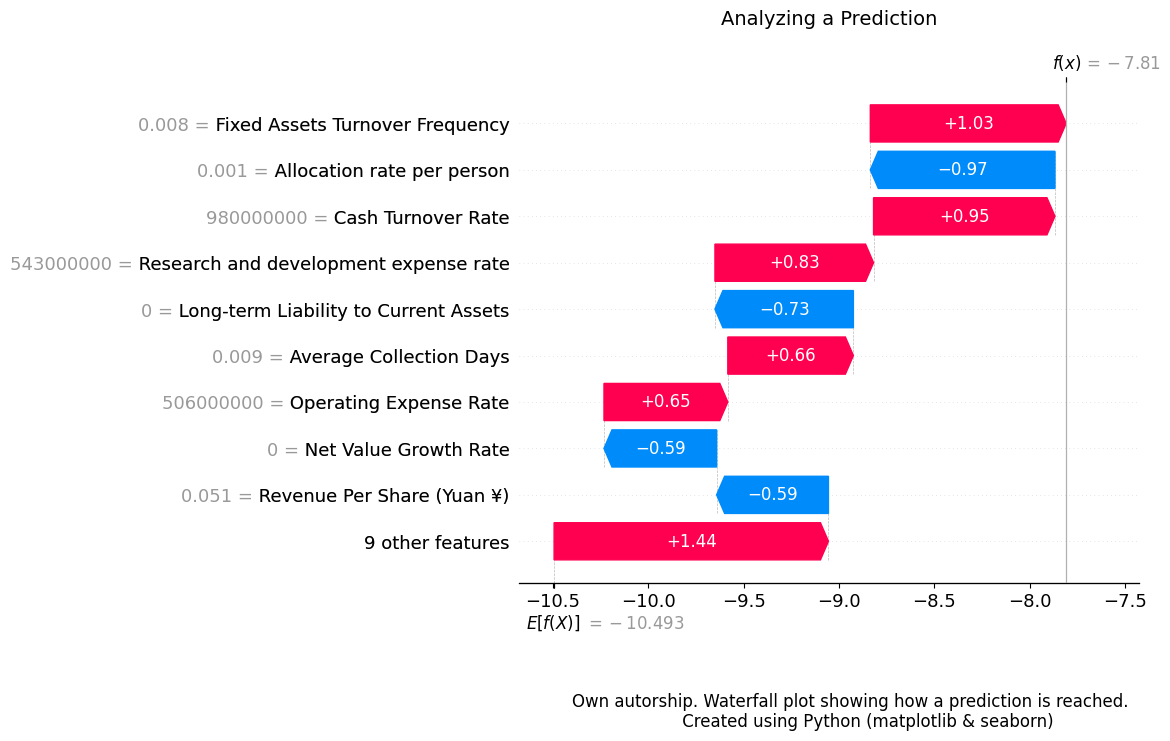

In [23]:
shap.plots.waterfall(shap_values[1], show=False)

# Add a title and axis labels
plt.title("Analyzing a Prediction", fontsize=14, pad=20)
plt.text(-10.4, -4, f'Own autorship. Waterfall plot showing how a prediction is reached. \n \
                    Created using Python (matplotlib & seaborn)', fontsize=12)
plt.grid()
# Display the plot
plt.show()

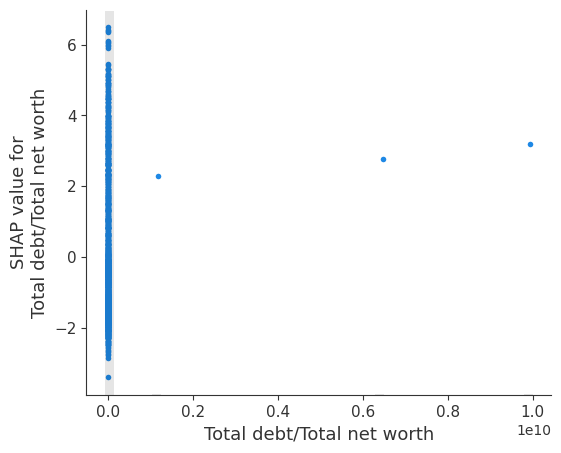

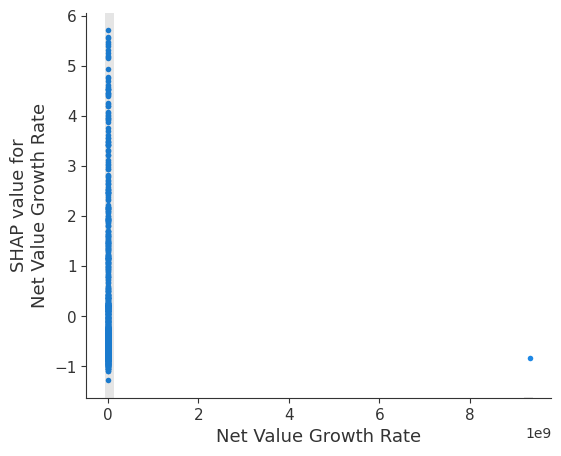

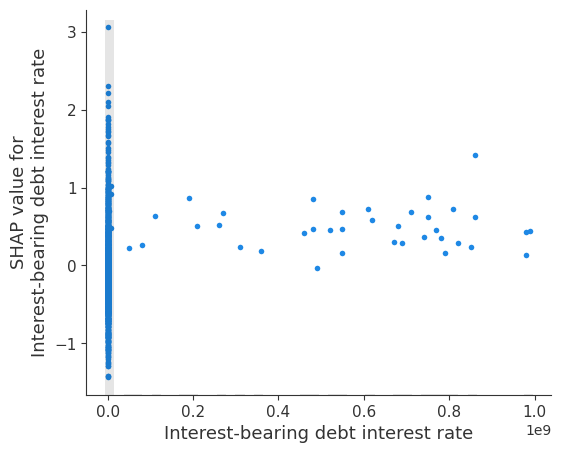

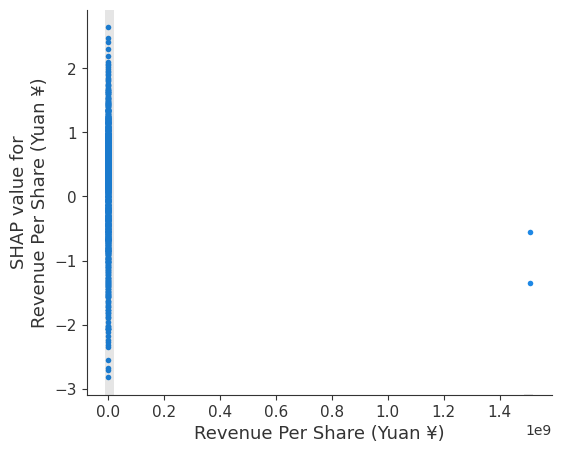

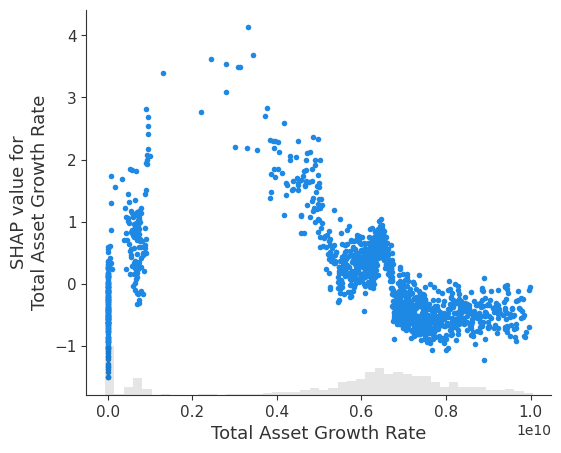

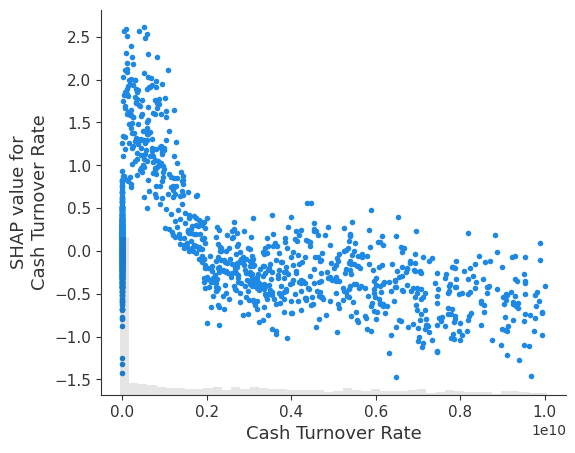

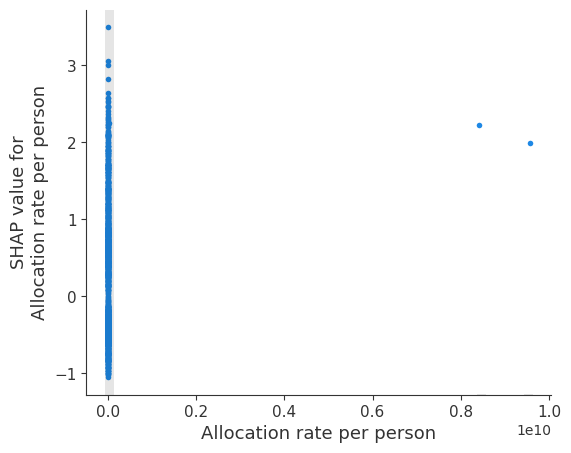

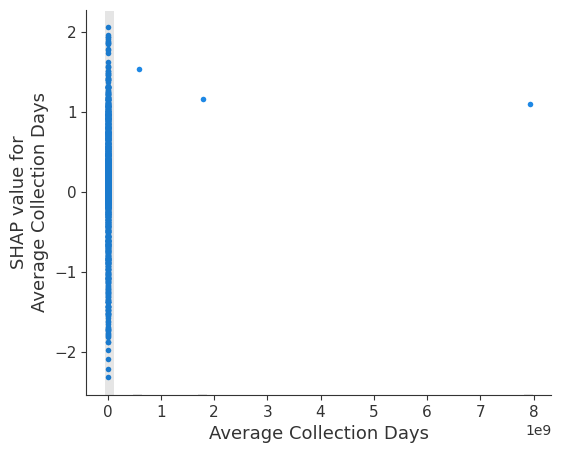

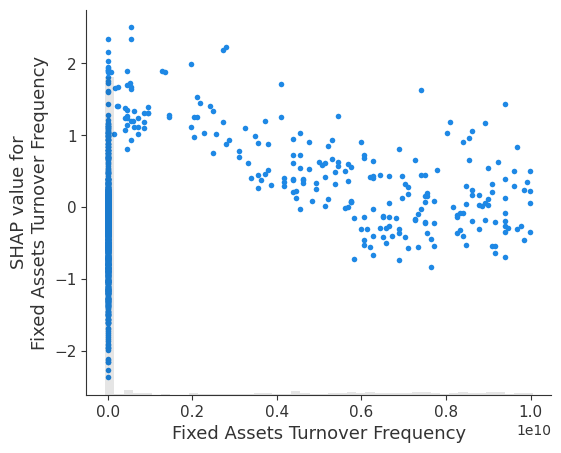

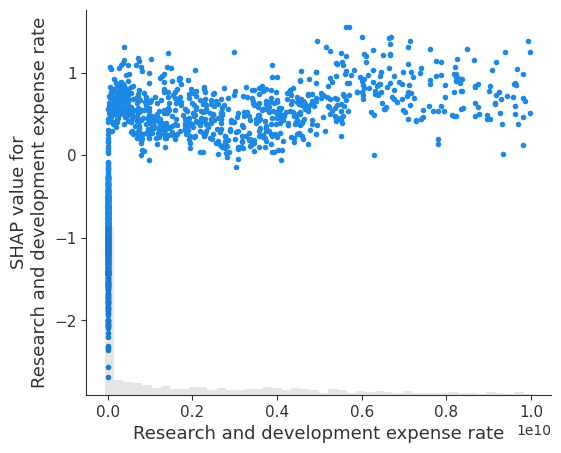

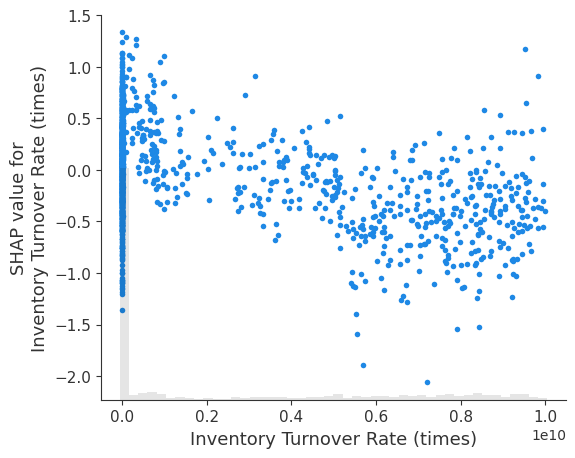

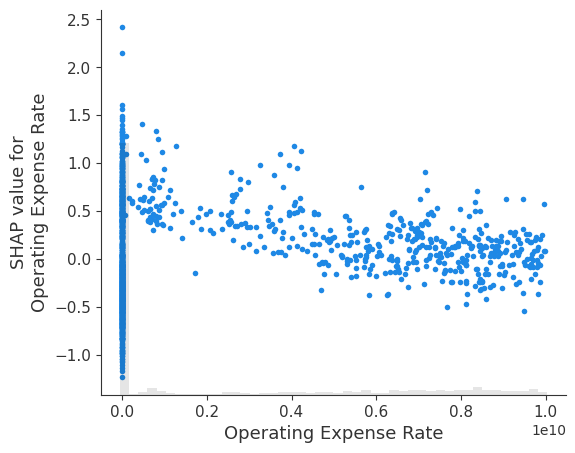

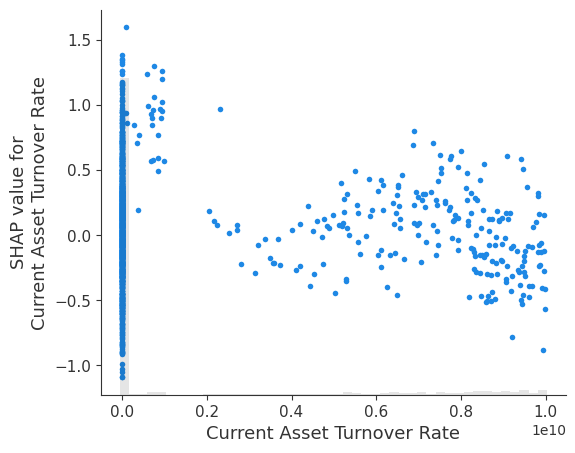

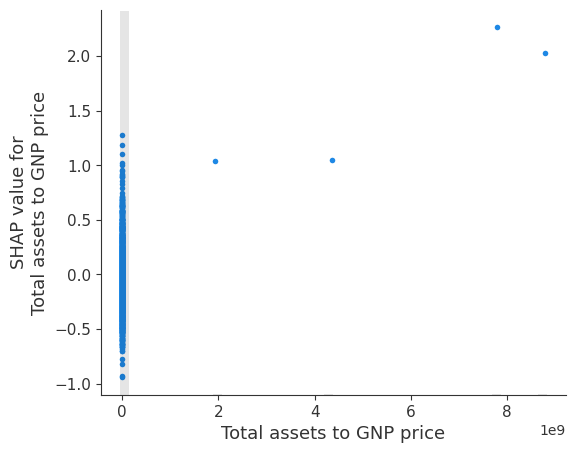

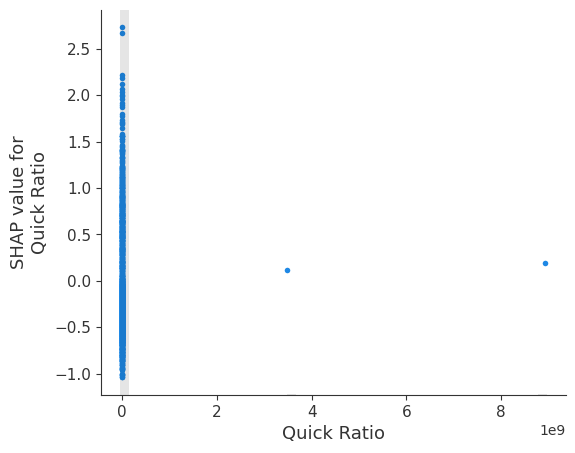

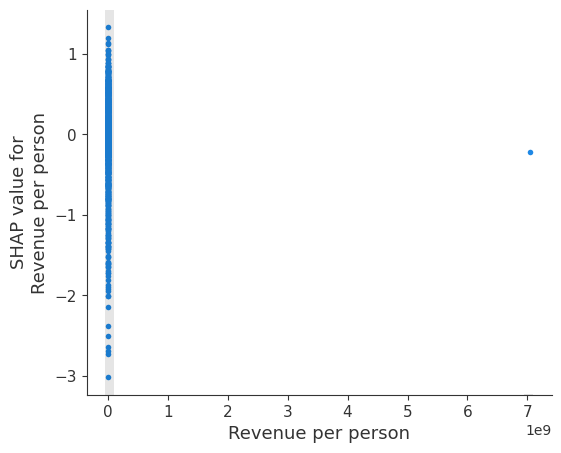

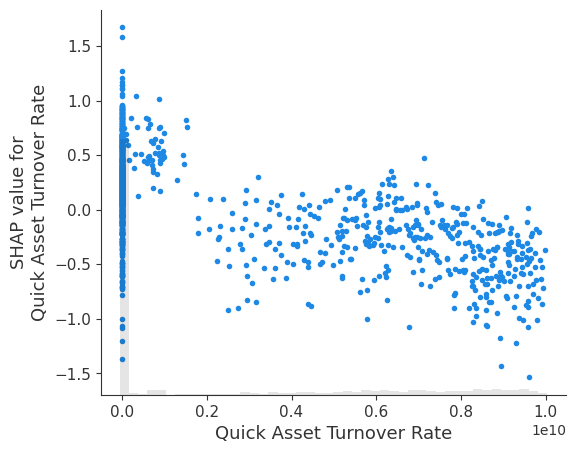

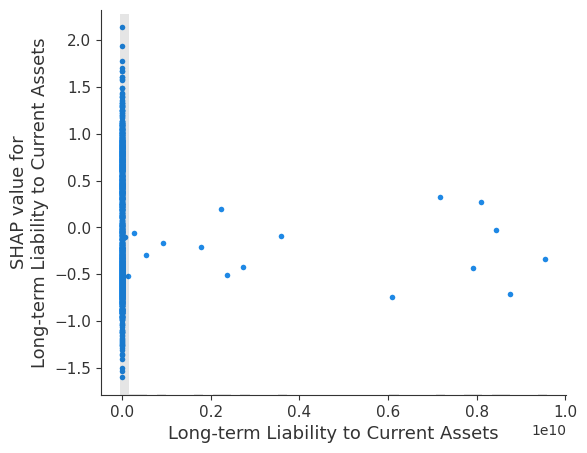

In [24]:
#Dependance Plot

for var in X.columns.tolist():
    shap.plots.scatter(shap_values[:, var])